In [1]:
# loading modules

import warnings 
warnings.filterwarnings("ignore")

import datetime
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import ticker, cm
import pop_tools as pt
import cartopy
import cartopy.crs as ccrs

In [2]:
import dask
import dask_jobqueue
import distributed

# this first part is checking you're in the right environment
if "client" in locals():
    client.close()
    del client
if "cluster" in locals():
    cluster.close()

# this is where we set up the cluster, your own compute system if you will 
cluster = dask_jobqueue.PBSCluster(
    cores=1,  # The number of cores you want
    memory="23GB",  # Amount of memory
    processes=1,  # How many processes
    queue="casper",  # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    # log_directory="/glade/scratch/dcherian/dask/",  # Use your local directory
    resource_spec="select=1:ncpus=1:mem=23GB",  # Specify resources
    project="uwis0040",  # Input your project ID here / THIS WILL BE DIFFERENT FOR YOU 
    walltime="00:20:00",  # Amount of wall time
    interface="ib0",  # Interface to use
)

# this is where we say that we want several of these compute systems,
# because we will have to deal with lots of data and can't just rely on one
cluster.adapt(maximum_jobs=24, minimum_jobs=2) # If you want to force everything to be quicker, 
# increase the number of minimum jobs, but sometimes then it will take a while until you get them assigned 
# (they have to queue), so it's a trade-off
client = distributed.Client(cluster)

# show the client that you have been assigned, you can click on the link and it will show you 
# a dashboard with all the tasks that have to be performed to do your calculation
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/deppenme/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/deppenme/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.205.12:39815,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/deppenme/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
## this dataset is monthly! we might need some daily data to consider the 5 day criterion
ds_sst = xr.open_dataset('HadISST_sst.nc')
ds_sst = ds_sst.sst.where(ds_sst.sst>-100)

In [6]:
ds_sst.attrs

{'standard_name': 'sea_surface_temperature',
 'long_name': 'sst',
 'units': 'C',
 'cell_methods': 'time: lat: lon: mean'}

CPU times: user 389 ms, sys: 140 ms, total: 528 ms
Wall time: 572 ms


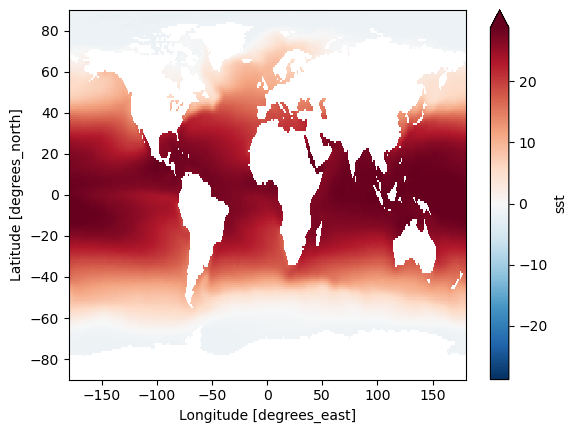

In [4]:
ds_sste
ds_sst.mean('time').plot(robust=True)

## Marine Heat Waves Metrics
- 90th percentile 
- 95th percentile 
- 1C warmer than warmest __mean__ summer time SST
- how do daily estimates compare to monthly based estimates? 

See additional metric examples in Hobday et al. table: https://www.sciencedirect.com/science/article/pii/S0079661116000057
including
- maximum temperature
- thermal stress anomaly
- degree heating days/weeks



### Warmer than (Summer) Season Mean 

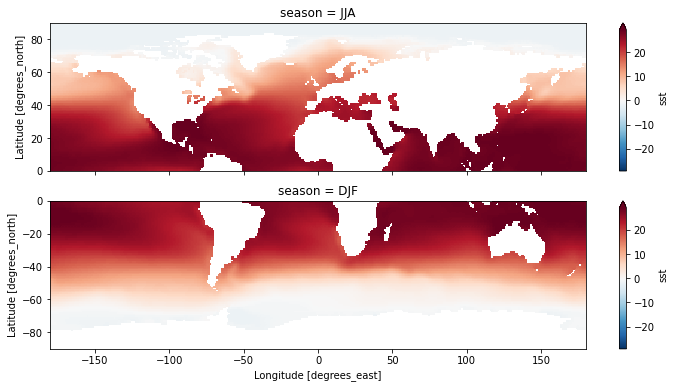

In [6]:
# step one get the season means for summer per hemisphere 

fig, ax = plt.subplots(2, 1, figsize=(12,6), sharex=True)

ds_sst.groupby('time.season').mean('time').sel(season='JJA', latitude=slice(90,0)).plot(robust=True, ax=ax[0])
ax[0].set_xlabel('')

ds_sst.groupby('time.season').mean('time').sel(season='DJF', latitude=slice(0,-90)).plot(robust=True, ax=ax[1])


In [9]:
# this gets to the seasonal anomalies 
sst_anoms = ds_sst.groupby('time.season') - ds_sst.groupby('time.season').mean('time')
# summer time might not be the right thing to go for. maybe it's better to make a monthly climatology and subtract that. 


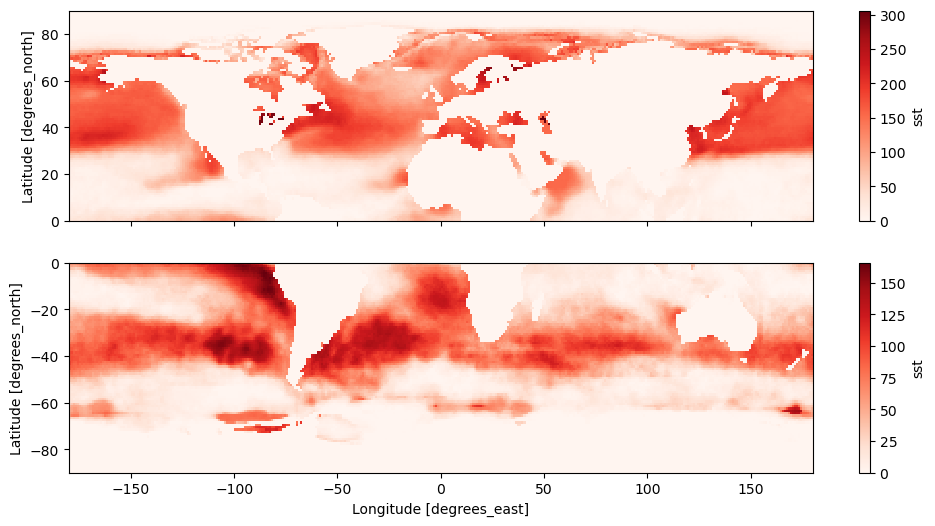

In [10]:
# this counts the instances when SST at any time exceeds max summer time sst by 1degree

fig, ax = plt.subplots(2, 1, figsize=(12,6), sharex=True)
(sst_anoms.where(sst_anoms>1)
 .sel(time=sst_anoms.time.dt.season.isin('JJA')).count(dim='time')
 .sel(latitude=slice(90,0))).plot(cmap='Reds', ax=ax[0])
ax[0].set_xlabel('')

(sst_anoms.where(sst_anoms>1)
 .sel(time=sst_anoms.time.dt.season.isin('DJF')).count(dim='time')
 .sel(latitude=slice(0,-90))).plot(cmap='Reds', ax=ax[1])


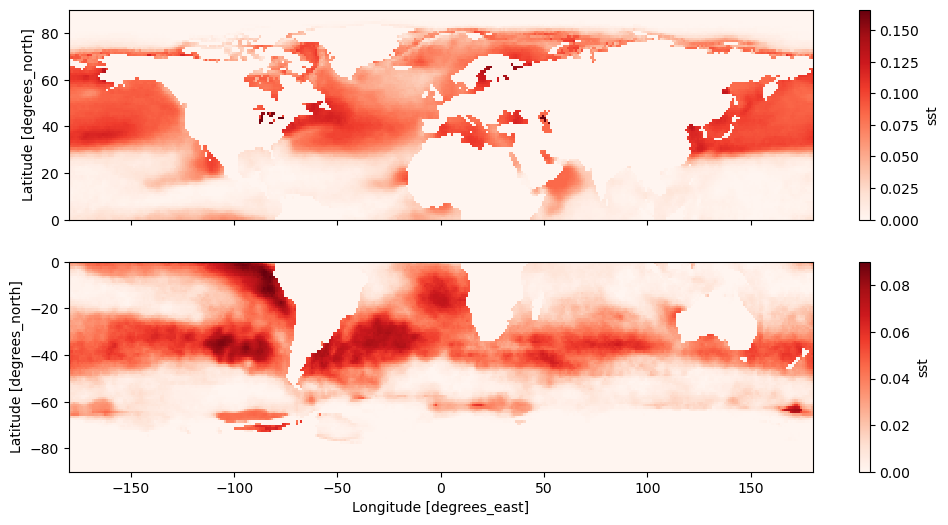

In [11]:
# this counts the instances when SST at any time exceeds max summer time sst by 1degree
# in percents

# nothern half where summer is JJA
fig, ax = plt.subplots(2, 1, figsize=(12,6), sharex=True)
(sst_anoms.where(sst_anoms>1)
 .sel(time=sst_anoms.time.dt.season.isin('JJA')).count(dim='time')
 .sel(latitude=slice(90,0)) / len(sst_anoms.time)).plot(cmap='Reds', ax=ax[0])
ax[0].set_xlabel('')

# southern half where summer is DJF
(sst_anoms.where(sst_anoms>1)
 .sel(time=sst_anoms.time.dt.season.isin('DJF')).count(dim='time')
 .sel(latitude=slice(0,-90))  / len(sst_anoms.time)).plot(cmap='Reds', ax=ax[1])


In [9]:
# next steps: come up with a way to make it percentage based? so that you can compare 
# also does it really make sense to restrict this to summer? Maybe I should do this monthly and also  I should 
# check in all seasons when for instances that exceed the max summer clim ; maybe make seasonal cycle of this? 
# how many occurence of 

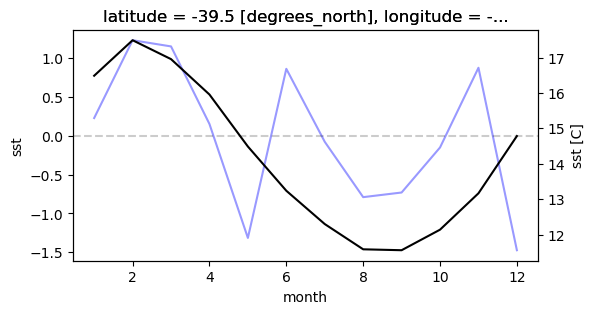

In [12]:
# checking when the anomalies are largest compared to the seasonal cycle -- should we use this in some metric? 
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
sst_anoms.sel(latitude=-40, longitude=-100, method='nearest').groupby('time.month').mean('time').plot(ax=ax, c='blue', alpha=0.4)
plt.gca().axhline(0, ls='--', c='k', alpha=0.2)
# for year in range(1870, 2023):
#     sst_anoms.sel(latitude=-40, longitude=-100, method='nearest').sel(time=year).groupby('time.month').mean('time').plot(c='k', alpha=0.2, ls=':')

ax1 = ax.twinx()
ds_sst.sel(latitude=-40, longitude=-100, method='nearest').groupby('time.month').mean('time').plot(ax=ax1, c='k')


### Percentiles / Quantiles

(array([ 11.,  43., 199., 421., 467., 387., 191.,  85.,  25.,  10.]),
 array([-3.05908203, -2.39446449, -1.72984695, -1.06522942, -0.40061188,
         0.26400566,  0.9286232 ,  1.59324074,  2.25785828,  2.92247581,
         3.58709335]),
 <BarContainer object of 10 artists>)

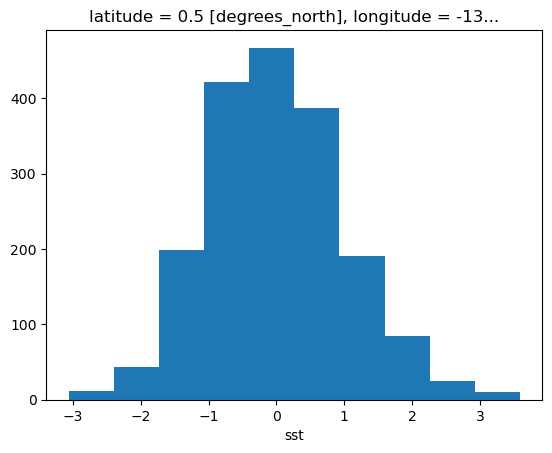

In [13]:
xr.plot.hist(sst_anoms.sel(latitude=0, longitude=-140, method='nearest'))

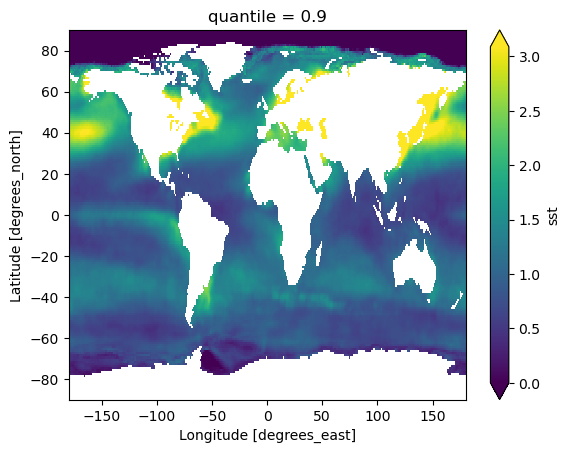

In [14]:
sst_anoms.quantile(0.90, dim='time').plot(robust=True)

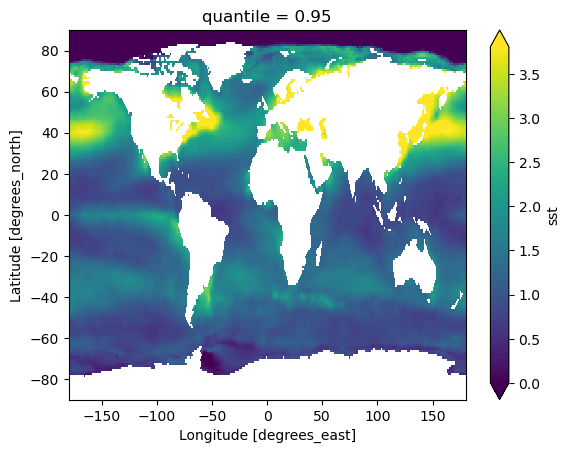

In [15]:
sst_anoms.quantile(0.95, dim='time').plot(robust=True)

#### Temperature anomalies

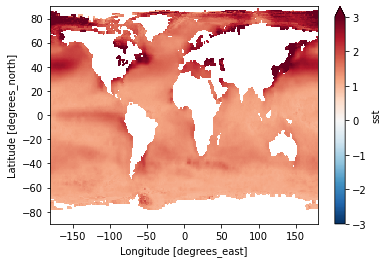

In [18]:
#at least 1 degree anomaly using monthly anoms, year round
sst_anoms.where(sst_anoms>1).mean('time').plot(robust=True, cmap=plt.cm.RdBu_r, vmin=-3,vmax=3)

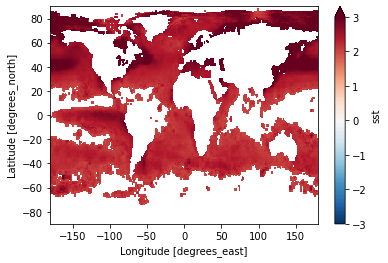

In [20]:
#at least 2 degree anomaly using monthly anoms, year round
sst_anoms.where(sst_anoms>2).mean('time').plot(robust=True, cmap=plt.cm.RdBu_r, vmin=-3,vmax=3)

#add freuqnecy or number of events.

## Absolute Thresholds
- is this useful in any way? 
- maybe depending on the species? 

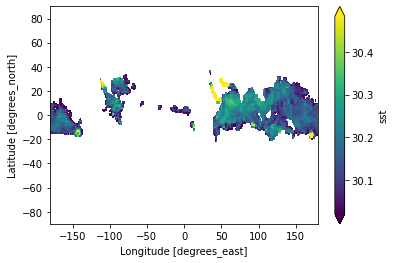

In [24]:
#above 30degC
ds_sst.where(ds_sst>30).mean('time').plot(robust=True)

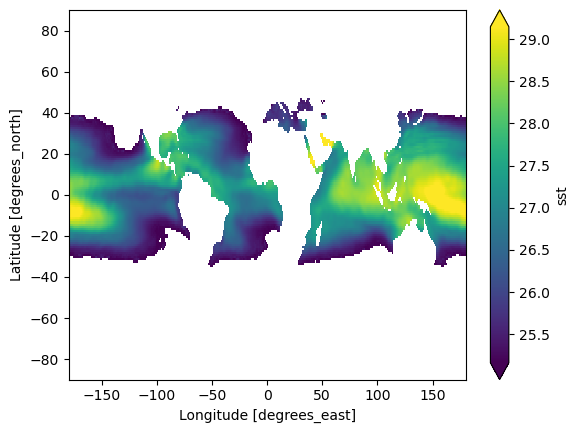

In [16]:
#above 25degC
ds_sst.where(ds_sst>25).mean('time').plot(robust=True)

### Daily vs Monthly data 

In [41]:
oisst_daily_path = '/glade/p/univ/cmia0001/Observations/OI.SST.v2/'
ds_oisst_daily = xr.open_mfdataset(oisst_daily_path + 'sst.day.mean.????.nc', parallel=True, chunks={'lat':10,'lon':10},\
                                  compat='override', coords='minimal').chunk({'time':13514})

oisst_clim_path = '/glade/scratch/emaroon/oisst/'
ds_oisst_daily_clim = xr.open_dataset(oisst_clim_path + 'sst.day.mean.ltm.1982-2010.nc')

In [27]:
oisst_clim_path = '/glade/scratch/emaroon/oisst/'
ds_oisst_daily_clim = xr.open_dataset(oisst_clim_path + 'sst.day.mean.ltm.1982-2010.nc')

In [42]:
ds_oisst_daily.sst

,Array,Chunk
Bytes,52.20 GiB,5.16 MiB
Shape,"(13514, 720, 1440)","(13514, 10, 10)"
Count,777637 Tasks,10368 Chunks
Type,float32,numpy.ndarray


In [11]:
ds_oisst_daily_clim.sst

<xarray.DataArray 'sst' (time: 365, lat: 720, lon: 1440)>
[378432000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time     (time) object 0001-01-01 00:00:00 ... 0001-12-31 00:00:00
Attributes:
    long_name:     Daily Long Term Mean Sea Surface Temperature
    units:         degC
    valid_range:   [-3. 45.]
    precision:     2.0
    dataset:       NOAA High-resolution Blended Analysis
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Long Term Mean
    parent_stat:   Mean
    actual_range:  [-1.8     34.27655]

#### Hobday metric

In [49]:
#per hobday metric, need at least 5-days above 90th percentile 

#do 11 day centering rolling mean for both anomalies and climatology
#do rolling 1st then climo b/c of end of year rollover

hobday_rolledmean = ds_oisst_daily.sst.rolling(time=11, center=True).mean()
hobday_climo = hobday_rolledmean.groupby('time.dayofyear').mean('time')

#plt.plot(hobday_climo.sel(lat=30,lon=170, method='nearest'))

In [ ]:
#calculate anomalies
hobday_anom = hobday_rolledmean.groupby('time.dayofyear')-hobday_climo

In [ ]:
#calculate 90th percentile anomalies


In [ ]:
#calculate 5-day consecutive anomalies above 90th percentile
